In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Load data

In [2]:
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:

# X_train = []
# y_train = []

# for batch_number in range(1, 6):
#     with open('cifar-10-batches-py/data_batch_{}'.format(batch_number), 'rb') as fo:
#         data = pickle.load(fo, encoding='bytes')
#     X_train.append(data[b'data'])
#     y_train.append(data[b'labels'])

# X_train = np.concatenate(X_train, axis=0)

# y_train = np.concatenate(y_train, axis=0)

# with open('cifar-10-batches-py/test_batch', 'rb') as fo:
#     data = pickle.load(fo, encoding='bytes')
# X_test = data[b'data']
# y_test = data[b'labels']

# Preprocess

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

In [8]:
class Processor(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.astype('float32') / 255
        y = to_categorical(y)
        
        return X, y

In [9]:
processor = Processor()
processor.fit(X_train)
X_train, y_train = processor.transform(X_train, y=y_train)
X_test, y_test = processor.transform(X_test, y_test)

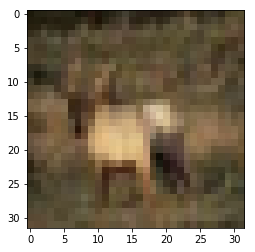

In [10]:
plt.imshow(X_train[3])

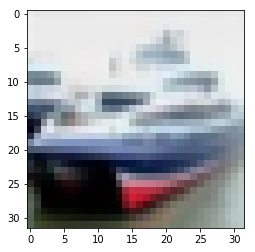

In [11]:
plt.imshow(X_test[1])

# Network

In [12]:
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

from keras.layers import concatenate

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [13]:
def inception(x_input):
    tower_0 = Conv2D(64, (1, 1), padding='same', activation='relu')(x_input)
    
    tower_1 = Conv2D(64, (1, 1), padding='same', activation='relu')(x_input)
    tower_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(tower_1)
    
    tower_2 = Conv2D(64, (1, 1), padding='same', activation='relu')(x_input)
    tower_2 = Conv2D(64, (5, 5), padding='same', activation='relu')(tower_2)
    
    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x_input)
    tower_3 = Conv2D(64, (1, 1), padding='same', activation='relu')(tower_3)
    
    output = concatenate([tower_0, tower_1, tower_2, tower_3], axis=3)
    
    return output

In [49]:
def cnn_inception():
    x_input = Input((32, 32, 3))
    x = inception(x_input)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(10, activation='softmax')(x)
    
    model = Model(x_input, x)
    return model

In [50]:
model = cnn_inception()

In [51]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 32, 32, 64)   256         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 32, 32, 64)   256         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 32, 32, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_25 

# Data generator

In [52]:
from keras.preprocessing.image import ImageDataGenerator

In [53]:
datagen = ImageDataGenerator(width_shift_range=0.1, 
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             validation_split=0.2)

In [54]:
training_generator = datagen.flow(X_train, y_train, batch_size=256,
                                 subset='training')
validation_generator = datagen.flow(X_train, y_train, batch_size=256,
                                 subset='validation')

# Training 

In [55]:
model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
earlystop = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint('cnn_inception.h5', save_best_only=True)
tensorboard = TensorBoard(log_dir='log/cnn_inception')

In [57]:
model.fit_generator(training_generator, epochs=20,
                    steps_per_epoch=X_train.shape[0]*0.8//256, 
                    validation_data=validation_generator, 
                    validation_steps=X_train.shape[0]*0.2//256,
                   callbacks=[earlystop, checkpoint, tensorboard])

Epoch 1/20
156/156 [==============================] - 24s 155ms/step - loss: 2.3927 - acc: 0.2238 - val_loss: 1.8483 - val_acc: 0.3321
Epoch 2/20
156/156 [==============================] - 24s 152ms/step - loss: 1.8322 - acc: 0.3267 - val_loss: 1.6537 - val_acc: 0.4127
Epoch 3/20
156/156 [==============================] - 24s 153ms/step - loss: 1.7136 - acc: 0.3675 - val_loss: 1.4947 - val_acc: 0.4638
Epoch 4/20
156/156 [==============================] - 24s 153ms/step - loss: 1.6476 - acc: 0.3920 - val_loss: 1.4736 - val_acc: 0.4825
Epoch 5/20
156/156 [==============================] - 24s 154ms/step - loss: 1.6013 - acc: 0.4012 - val_loss: 1.4360 - val_acc: 0.4887
Epoch 6/20
156/156 [==============================] - 24s 155ms/step - loss: 1.5649 - acc: 0.4123 - val_loss: 1.3983 - val_acc: 0.5013
Epoch 7/20
156/156 [==============================] - 24s 155ms/step - loss: 1.5399 - acc: 0.4256 - val_loss: 1.3898 - val_acc: 0.5148
Epoch 8/20
156/156 [==============================] - 2

# Evaluate 

In [59]:
model.evaluate(X_test, y_test, batch_size=256)

10000/10000 [==============================] - 2s 225us/step


[1.1704835206985473, 0.5792]